# Inputs to bolo-calc
This notebook documents where we got the various numbers that are used as inputs to bolo-calc for runs in this directory.

## Optics:  Dielectric losses

Loss tangents:
- Alumina:  
    - Using 3E-4 
    - 3E-4 (+- 1E-4) is value at 77K, from SPT3g, Nadolski etal, https://arxiv.org/abs/1912.04272 table 1.
- Silicon:  
    - Using Czochralski process silicon, which has some impurities.
    - Using 5.0E-5
    - Dutta etal, https://arxiv.org/pdf/1307.4715.pdf , gives an upper limit of 8e-5 at and below 30K for the worse sample.  So, 8e-5 would be very very conservative;  5e-5 is probably conservative.
 
- HDPE:  Using 0.8E-4, from ?

<BR>

Nylon loss:
- Halpern, Gush, Wishnow and de Cosmo, https://www.osapublishing.org/ao/abstract.cfm?uri=ao-25-4-565
- This is not well-charcterized by a loss tangent;  the loss goes as $\nu^{2.9}$ rather than $\nu^1$.  We work out the loss for each band center, below.

<BR>
        
RTMLI loss:
- This is a scatterer.  It is not obvious how it should scale with photon frequency, and there's very little data on "in-band" performance.  Bicep3 (https://arxiv.org/abs/1808.00567) does have an estimate of the loading (at 90GHz) from their RTMLI filters, though how it was arrived at is not well-described.  Below we make a model that matches their loading at 90GHz, and scales from there as $\nu^1$, where the index of that power law is arbitrarily chosen.

## Nylon filter 
Currently used only the SATs.
7.5mm thick

In [19]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 8]

sat_nus =   np.array([      25.75, 38.75, 85.0, 95.0, 145.0, 155.0, 227.0, 285.5])
#splat_nus = np.array([20.0, 25.75, 38.75, 91.5, 148.5,              227.0, 285.5])
#chlat_nus = np.array([      25.75, 38.75, 91.5, 148.5,              227.0, 285.5])

telescopes =['SAT'] #,'splat','chlat']
nu_dict = {'SAT':sat_nus, 'SPLAT':splat_nus, 'CHLAT':chlat_nus}

# From Halpern etal
a_nylon = 5e-4
b_nylon = 2.9
delta_z = 0.75 #cm

for tel in telescopes:
    print(tel)

    for nu in nu_dict[tel]:
        icm = nu/30.
        alpha_nylon = a_nylon*icm**b_nylon     # units are cm^-1
        transmission_nylon = np.exp(-alpha_nylon*delta_z)
        abs_nylon = 1-transmission_nylon  
        print('nu = {0:5.1f} GHz, icm={1:4.2f}, alpha={2:4.3f}, Abs = {3:7.4f}'.format(nu, icm, alpha_nylon, abs_nylon))

SAT
nu =  25.8 GHz, icm=0.86, alpha=0.000, Abs =  0.0002
nu =  38.8 GHz, icm=1.29, alpha=0.001, Abs =  0.0008
nu =  85.0 GHz, icm=2.83, alpha=0.010, Abs =  0.0077
nu =  95.0 GHz, icm=3.17, alpha=0.014, Abs =  0.0106
nu = 145.0 GHz, icm=4.83, alpha=0.048, Abs =  0.0355
nu = 155.0 GHz, icm=5.17, alpha=0.059, Abs =  0.0429
nu = 227.0 GHz, icm=7.57, alpha=0.177, Abs =  0.1243
nu = 285.5 GHz, icm=9.52, alpha=0.344, Abs =  0.2274


# RTMLI
I used a web app to grab some data points from 

REVIEW OF SCIENTIFIC INSTRUMENTS 84, 114502 (2013) <BR>
Radio-transparent multi-layer insulation for radiowave receivers <BR>
J. Choi,H. Ishitsuka,S. Mima,S. Oguri, K. Takahashi,and O. Tajima
    
This is not the same foam as used by Bicep or SPT3g, but it is the only source of good frequency dependent transmission that I'm aware of.  We'll use these data to find a plausible frequency power law scaling exponent for RTMLI.  We'll then use Bicep3 to normalize the in-band loss at 90GHz, and scale to other bands using the exponent found here. 

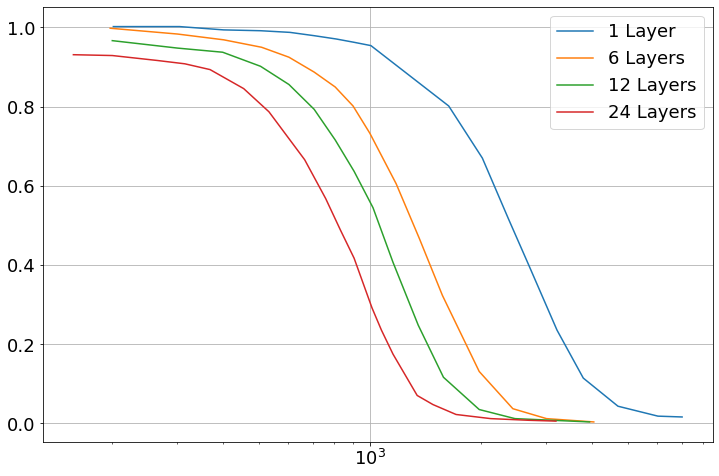

In [225]:
# Read in the data I screen-grabbed from Choi etal
nu1,rtmli_1 = np.loadtxt('rtmli_1.txt',unpack=True,delimiter=', ')
nu2,rtmli_2 = np.loadtxt('rtmli_2.txt',unpack=True,delimiter=', ')
nu3,rtmli_3 = np.loadtxt('rtmli_3.txt',unpack=True,delimiter=', ')
nu4,rtmli_4 = np.loadtxt('rtmli_4.txt',unpack=True,delimiter=', ')

# Plot it to make sure it makes sense.
plt.semilogx(nu1,rtmli_1,label='1 Layer')
plt.semilogx(nu2,rtmli_2,label='6 Layers')
plt.semilogx(nu3,rtmli_3,label='12 Layers')
plt.semilogx(nu4,rtmli_4,label='24 Layers')
plt.legend()
plt.grid()

1 Layer: a = 4.44e-06, b=2.72
6 Layers: a = 3.12e-06, b=2.78
12 Layers: a = 4.00e-06, b=2.69
24 Layers: a = 9.26e-06, b=2.44


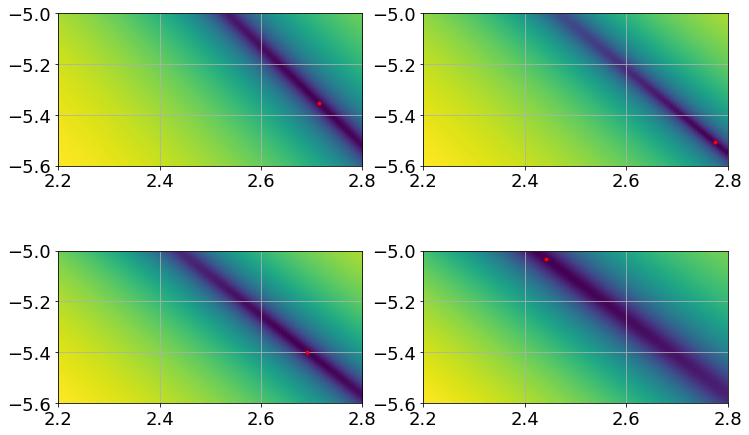

In [228]:
# Define some functions

def trans_dev(a,b,nlayers,data,nus):
    '''  calculate a chisquare between a model and data(nu).  
    '''
    alphaz = a*nlayers*(nus/30)**b
    T = np.exp(-alphaz)
    sumdev = np.sum((T-data)**2)
    return sumdev

def fitgoodness(nlayers,data,nus):
    '''  Over a broad grid in parameters (a,b), calculate the chisq and return an array.
         We're doing this rather than a fancy minimization because we want to see the 
         structure and compare results for different layers.
    '''
    aii = 0
    for a in avec:
        bii = 0
        for b in bvec:
            resultarr[bii,aii]=trans_dev(a,b,nlayers,data,nus)
            bii += 1
        aii += 1
    return resultarr

def minlocation(avec,bvec,resultarr):
    ''' Find the values of parameters (a,b) at the chisq minimum.
    '''
    a_ii = np.where(resultarr==np.min(resultarr))[1][0]
    a_value = avec[a_ii]
    b_ii = np.where(resultarr==np.min(resultarr))[0][0]
    b_value = bvec[b_ii]
    return a_value,b_value


# Set the ranges of (a,b) for our grid.
bmin = 2.2
bmax = 2.8
amin = -5.6
amax = -5
bvec = np.linspace(bmin,bmax,100)
avec = np.logspace(amin,amax,200)
resultarr = np.zeros((len(bvec),len(avec)))

fig,axs = plt.subplots(2,2)
aspects=.5  # This sets the aspect ratio of each subplot.

data = rtmli_1
nus = nu1
nlayers=1
resultarr=fitgoodness(nlayers,data,nus)
aval,bval = minlocation(avec,bvec,resultarr)
print('1 Layer: a = {0:4.2e}, b={1:3.2f}'.format(aval,bval))
#axs[0,0].contour(np.log(resultarr),origin='lower',extent=[amin,amax,bmin,bmax])
axs[0,0].imshow(np.log(resultarr).T,origin='lower',extent=[bmin,bmax,amin,amax])
axs[0,0].plot(bval,np.log10(aval),'.r')
axs[0,0].set_aspect(aspects)
axs[0,0].grid()

data = rtmli_2
nus = nu2
nlayers=6
resultarr=fitgoodness(nlayers,data,nus)
aval,bval = minlocation(avec,bvec,resultarr)
print('6 Layers: a = {0:4.2e}, b={1:3.2f}'.format(aval,bval))
#axs[0,0].contour(np.log(resultarr),origin='lower',extent=[amin,amax,bmin,bmax])
axs[0,1].imshow(np.log(resultarr).T,origin='lower',extent=[bmin,bmax,amin,amax])
axs[0,1].plot(bval,np.log10(aval),'.r')
axs[0,1].set_aspect(aspects)
axs[0,1].grid()

data = rtmli_3
nus = nu3
nlayers=12
resultarr=fitgoodness(nlayers,data,nus)
aval,bval = minlocation(avec,bvec,resultarr)
print('12 Layers: a = {0:4.2e}, b={1:3.2f}'.format(aval,bval))
#axs[0,0].contour(np.log(resultarr),origin='lower',extent=[amin,amax,bmin,bmax])
axs[1,0].imshow(np.log(resultarr).T,origin='lower',extent=[bmin,bmax,amin,amax])
axs[1,0].plot(bval,np.log10(aval),'.r')
axs[1,0].set_aspect(aspects)
axs[1,0].grid()

data = rtmli_4
nus = nu4
nlayers=24
resultarr=fitgoodness(nlayers,data,nus)
aval,bval = minlocation(avec,bvec,resultarr)
print('24 Layers: a = {0:4.2e}, b={1:3.2f}'.format(aval,bval))
#axs[1,1].contour(np.log(resultarr).T,origin='lower',extent=[bmin,bmax,amin,amax])
axs[1,1].imshow(np.log(resultarr).T,origin='lower',extent=[bmin,bmax,amin,amax])
axs[1,1].plot(bval,np.log10(aval),'.r')
axs[1,1].set_aspect(aspects)
axs[1,1].grid()



Based on those plots, we're going to adopt the values for the 12-layer fit, and see what happens if we use those for all four data sets.  Let's plot the data (for each value of layers) vs the model. 

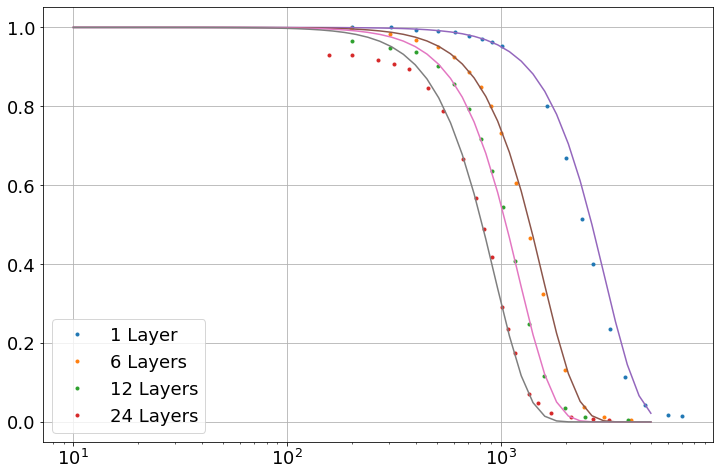

In [242]:
%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 8]

nu_ghz = np.logspace(1,3.7,50)
a = 4.00e-6
b = 2.69

# 1 layer
nlayers=1

plt.semilogx(nu1,rtmli_1,'.',label='1 Layer')
plt.semilogx(nu2,rtmli_2,'.',label='6 Layers')
plt.semilogx(nu3,rtmli_3,'.',label='12 Layers')
plt.semilogx(nu4,rtmli_4,'.',label='24 Layers')
plt.legend()

for nlayers in [1,6,12,24]:
    alphaz = a*nlayers*(nu_ghz/30)**b
    T = np.exp(-alphaz)
    plt.semilogx(nu_ghz,T)


plt.grid()

These look pretty good, so we're going to use b = 2.69, rounded to 2.7 .   We'll now go and recalculate "a" from Bicep3.

Table 2 in https://arxiv.org/pdf/1808.00567.pdf (Kange etal, "2017 upgrade and performance of BICEP3: a 95GHz
refracting telescope for degree-scale CMB polarization") says the RTMLI foam filter stack has an RJ temperature of 0.79K.   

Ignoring the very small transmission loss in each layer, 
the RJ loading is 

$$ T_{RJ} = \sum \epsilon T_i = N \epsilon \frac{\sum T_i}{N} = N \epsilon T_{avg} ,$$

where $\epsilon$ is the emissivity (loss) in a single layer.

The stack is located between the ambient (say 250K) foam window and the 50K alumina filter.  Let's say the top is at 220K, the bottom at 60K, giving $T_{avg} = 140$K.



Bicep3, 90GHz, 1 layer abs = 5.64e-04
              10 layer abs = 5.64e-03


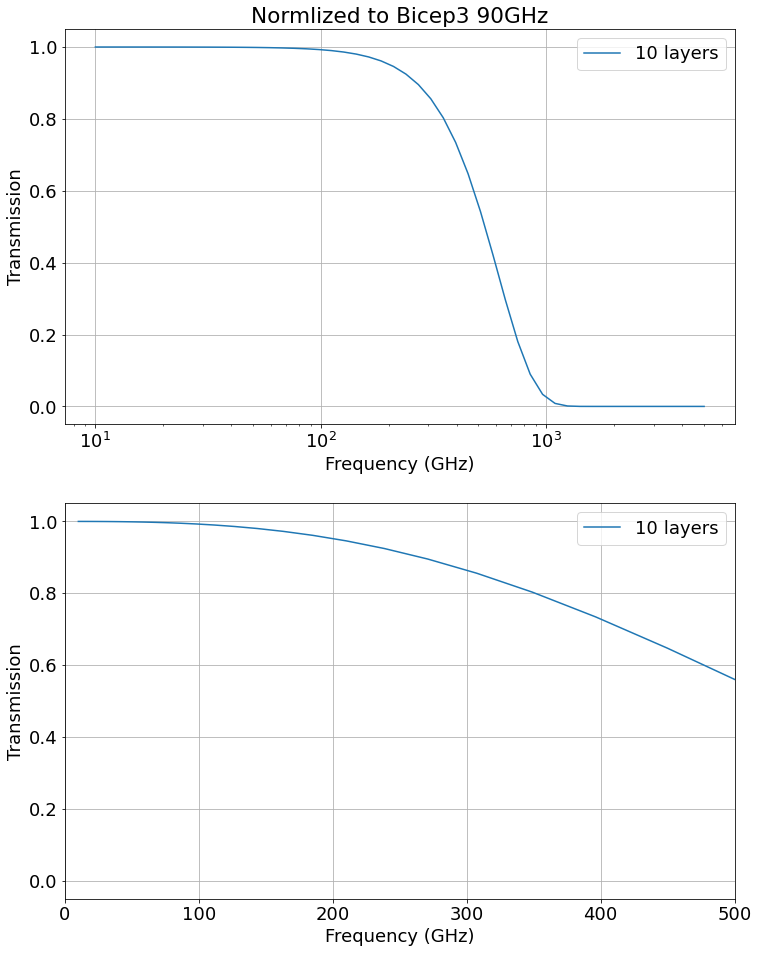

In [254]:
#  Bicep 3
Trj = 0.79 #K
Nlayers = 10
Tavg = 140 #K

abs_1layer = Trj/(Nlayers*Tavg)
print('Bicep3, 90GHz, 1 layer abs = {0:4.2e}'.format(abs_1layer))
print('              10 layer abs = {0:4.2e}'.format(abs_1layer*10))

# Now plot that using nu^2.7
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 16]

alphaN = Nlayers*abs_1layer*(nu_ghz/90.)**2.7
abs_Nlayers = np.exp(-alphaN)
T_Nlayers = 1- abs_Nlayers

plt.subplot(2,1,1)
plt.semilogx(nu_ghz,abs_Nlayers,label='10 layers')
plt.title('Normlized to Bicep3 90GHz')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(nu_ghz,abs_Nlayers,label='10 layers')
plt.xlim(0,500)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission')
plt.legend()
plt.grid()